In [26]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy
from collections import defaultdict
import importlib
import pprint

from interval import interval

import screed

import alignplot
importlib.reload(alignplot)

from alignplot import StackedDotPlot
from alignplot import AlignmentDiagram

import numpy as np

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

In [27]:
if 1:
    dotplot = StackedDotPlot('GCA_003222275.1',
                             ['GCA_003220225.1'],
                             'list.csv', './genomes', use_mashmap=True)

['./genomes/GCA_003222275.1_ASM322227v1_genomic.fna']
found queryfile for GCA_003222275.1: ./genomes/GCA_003222275.1_ASM322227v1_genomic.fna
found targetfile for GCA_003220225.1: ./genomes/GCA_003220225.1_ASM322022v1_genomic.fna


running mashmap...
running mashmap -q ./genomes/GCA_003222275.1_ASM322227v1_genomic.fna -r ./genomes/GCA_003220225.1_ASM322022v1_genomic.fna -o /var/folders/y6/s1r3q87933s6gjdrtmts1npc0000gq/T/tmp22gl9j40/mashmap.out --pi 95
...done! reading output from /var/folders/y6/s1r3q87933s6gjdrtmts1npc0000gq/T/tmp22gl9j40/mashmap.out.
shared w/Candidatus Rokubacteria bacterium: 435.6kb


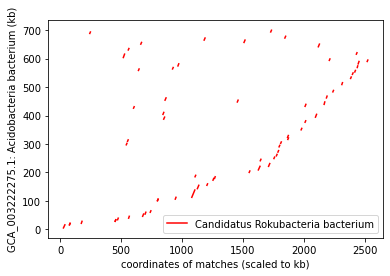

In [28]:
_ = dotplot()

In [29]:
dotplot = StackedDotPlot('GCF_001683825.1', ('GCF_000181835.1',), 'list.csv', './genomes')

['./genomes/GCF_001683825.1_ASM168382v1_genomic.fna']
found queryfile for GCF_001683825.1: ./genomes/GCF_001683825.1_ASM168382v1_genomic.fna
found targetfile for GCF_000181835.1: ./genomes/GCF_000181835.1_ASM18183v1_genomic.fna


running nucmer & show-coords for ./genomes/GCF_000181835.1_ASM18183v1_genomic.fna...
...done! reading output from /var/folders/y6/s1r3q87933s6gjdrtmts1npc0000gq/T/tmpyqgxlvkj.
shared w/Bacillus anthracis str. A0488: 269.5kb


NameError: name 'alignplot' is not defined

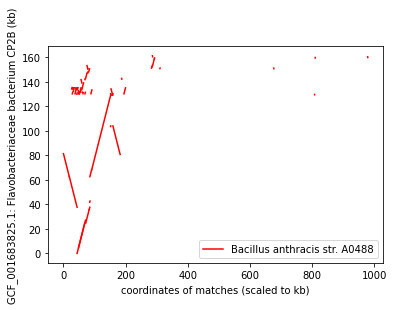

In [30]:
alignme = AlignmentDiagram(dotplot)
alignme.calculate()
fig = alignme.plot(use_labels=True)
fig.set_size_inches(10,8)
plt.savefig('/tmp/foo.png')

In [ ]:
alignme.calculate(plot_all_contigs=True)
fig = alignme.plot(use_labels=False)
fig.set_size_inches(10,8)
plt.savefig('/tmp/foo2.png')